# 10. Seq2seq와 Attention
---
언어 모델이 발전해 온 과정에 대해 개략적으로 공부하고, NLP의 큰 흐름 중 하나인 Sequence to Sequence(Seq2seq)에 대해 공부합니다. 이를 발전시키기 위한 기법이자 지금은 없어선 안 될 중요한 메커니즘인 Attention에 대해서도 살펴볼 거고요. 부디 즐거운 시간이 되시길 바랍니다!

10-1. 들어가며<br>
10-2. 우리가 만드는 언어 모델<br>
10-3. Sequence to Sequence 문제<br>
10-4. Sequence to Sequence 구현<br>
10-5. Attention! (1) Bahdanau Attention<br>
10-6. Attention! (2) Luong Attention<br>
10-7. 트랜스포머로 가기 전 징검다리?<br>
10-8. 마무리하며

## 10-1. 들어가며
---

### 학습 목표

- 언어 모델이 발전해 온 과정을 개략적으로 설명할 수 있다.
- 기존 RNN 기법이 번역에서 보인 한계를 파악하고, 이를 개선한 `Seq2seq`를 이해할 수 있다.
- Seq2seq를 발전시킨 `Attention`에 대해 설명할 수 있다.

## 10-2. 우리가 만드는 언어 모델
---

- 언어 모델(Language Model) : 단어의 시퀀스를 보고 다음 단어에 **확률을 할당** 하는 모델
    - n-1개의 단어 시퀀스 w1, w2, ... wn-1 가 주어졌을 때, n번째 단어 wn으로 무엇이 올 지 예측하는 확률 모델로 표현
    - 파라미터 θ로 모델링하는 언어 모델을 다음과 같이 표현
    - `P(wn|w1,...,wn-1;θ)`


- 언어 모델의 발전
    1. [통계적 언어 모델](https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/09/16/LM/) (Statistical Language Model)
    2. [신경망 언어 모델](https://wikidocs.net/45609) (Neural Network Language Model, NNLM)
    3. 순환 신경망(Recurrent Neural Network, 이하 RNN)을 활용한 언어 모델
    

- 희소문제(sparsity problem): 모델이 충분한 데이터를 관측하지 못하면 언어를 정확히 모델링 할 수 없는 문제를 말한다. <u>한 번도 관측하지 못한</u> 데이터에 대해선 **0에 확률을 부여**한다는 것에서 문제가 발생

## 10-3. Sequence to Sequence 문제
---

- 통계적 언어 모델 : 기존 n-gram 언어모델
>(1) 𝑃(𝑇𝑜𝑑𝑎𝑦 𝑖𝑠 𝑊𝑒𝑑𝑛𝑒𝑠𝑑𝑎𝑦)=0.001<br>
>(2) 𝑃(𝑇𝑜𝑑𝑎𝑦 𝑊𝑒𝑑𝑛𝑒𝑠𝑑𝑎𝑦 𝑖𝑠)=0.0000000001<br>
>**단점** : 충분한 데이터가 없다면 범용적인 모델을 구축하기 어려움<br>
>이유 : 한 번도 본 적 없는(학습 데이터에 존재하지 않는) 단어/문장에 대해서는 확률을 부여할 수 없다.<br>
> 따라서 언어 모델이 아우르는 범위를 넓히기 위해 다양한 단어를 포함하는 데이터가 필요하다. <br>
>(양까지 충분하다면 정의하는 확률이 일반적이므로 더욱 좋다.)

- NNLM : 희소문제 해결
> one-hot vector(input) <br>
>-> concat~lookup-table, projection layer(linear) <br>
>-> hidden layer(nonlinear) <br>
>-> output layer ~ cross-entropy ~ output <br>
> 장점 : 본적없는 단어/문장도 embedding을 통해 예측 가능
> 단점 : 여전히 고정된 길이의 단어셋 사용

- RNN : 
> 전체 문장을 볼 수 있지만, 
> 정보가 길어질수록 Vanishing Gradient 문제 -> LSTM으로 개선
> 문장 생성에는 적합한데 번역에는 사용하기 어려움

- [Sequence to sequence](https://reniew.github.io/35/):
> 논문: [Sequence to Sequence Learning with Neural Networks](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)<br>
>번역에 있어서는 문장을 다 읽고 번역하는, 즉 문장 전체를 보고 나서 생성하는 구조가 필요했습니다. 이에 2014년, 구글이 Sequence to Sequence(Seq2Seq) 구조를 제안<br>
>https://wikidocs.net/24996

### Seq2seq

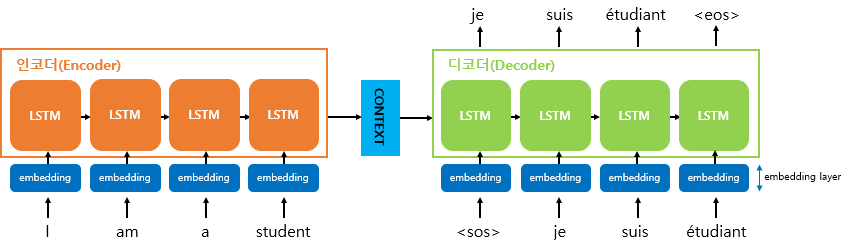
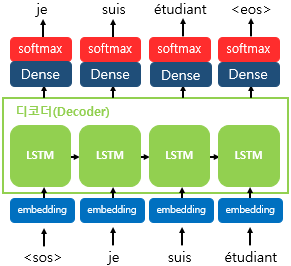


## 10-4. Sequence to Sequence 구현
---

일단은 데이터를 직접 다루기보다는 차원 수를 확인하는 실습

### 1) LSTM Encoder


In [1]:
import tensorflow as tf


class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(enc_units) # return_sequences 매개변수를 기본값 False로 전달

  def call(self, x):
    print("입력 Shape:", x.shape)

    x = self.embedding(x)
    print("Embedding Layer를 거친 Shape:", x.shape)

    output = self.lstm(x)
    print("LSTM Layer의 Output Shape:", output.shape)

    return output

Embedding 레이어를 
- 단어 사이즈와 
- Embedding 차원에 대해 선언을 한 후, 

논문에서 소개한 대로 tf.keras.layers.LSTM(enc_units)으로 LSTM을 정의합니다. 

TensorFlow 속 LSTM 모듈의 
- 기본 반환 값은 최종 State 값

이므로 
- return_sequences 나 
- return_state 값은 따로 조정하지 않습니다 (기본: False).

즉, 우리가 정의해 준 
- Encoder 클래스의 반환 값이 
- 곧 컨텍스트 벡터(Context Vector) 가 되는 겁니다. 

추가적인 옵션이 궁금하시다면 아래의 TensorFlow LSTM 공식 문서를 참조하시면 좋습니다.

In [2]:
# 매개변수 설정
vocab_size = 30000
emb_size = 256
lstm_size = 512
batch_size = 1
sample_seq_len = 3

print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

Vocab Size: 30000
Embedidng Size: 256
LSTM Size: 512
Batch Size: 1
Sample Sequence Length: 3



In [3]:
# 인코더 모양 확인
encoder = Encoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

sample_output = encoder(sample_input)    # 컨텍스트 벡터로 사용할 인코더 LSTM의 최종 State값

입력 Shape: (1, 3)
Embedding Layer를 거친 Shape: (1, 3, 256)
LSTM Layer의 Output Shape: (1, 512)


### 2) LSTM Decoder


In [4]:
# Encoder 구현에 사용된 변수들을 이어 사용함에 유의!

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(dec_units,
                                     return_sequences=True) # return_sequences 매개변수를 True로 설정
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.softmax = tf.keras.layers.Softmax(axis=-1)

  def call(self, x, context_v):  # 디코더의 입력 x와 인코더의 컨텍스트 벡터를 인자로 받는다. 
    print("입력 Shape:", x.shape)

    x = self.embedding(x)
    print("Embedding Layer를 거친 Shape:", x.shape)

    context_v = tf.repeat(tf.expand_dims(context_v, axis=1),
                          repeats=x.shape[1], axis=1)
    x = tf.concat([x, context_v], axis=-1)  # 컨텍스트 벡터를 concat 해준다
    print("Context Vector가 더해진 Shape:", x.shape)

    x = self.lstm(x)
    print("LSTM Layer의 Output Shape:", x.shape)

    output = self.fc(x)
    print("Decoder 최종 Output Shape:", output.shape)

    return self.softmax(output)

print("슝~")

슝~


Decoder가 매 스텝 생성하는 출력은 우리가 원하는 "번역 결과"에 해당

하므로 LSTM 레이어의 "return_sequences 변수를 True로 설정"하여 State 값이 아닌 Sequence 값을 출력으로 받습니다.

In [5]:
print("Vocab Size: {0}".format(vocab_size))
print("Embedidng Size: {0}".format(emb_size))
print("LSTM Size: {0}".format(lstm_size))
print("Batch Size: {0}".format(batch_size))
print("Sample Sequence Length: {0}\n".format(sample_seq_len))

Vocab Size: 30000
Embedidng Size: 256
LSTM Size: 512
Batch Size: 1
Sample Sequence Length: 3



In [7]:
decoder = Decoder(vocab_size, emb_size, lstm_size)
sample_input = tf.zeros((batch_size, sample_seq_len))

dec_output = decoder(sample_input, sample_output)  # Decoder.call(x, context_v) 을 호출

입력 Shape: (1, 3)
Embedding Layer를 거친 Shape: (1, 3, 256)
Context Vector가 더해진 Shape: (1, 3, 768)
LSTM Layer의 Output Shape: (1, 3, 512)
Decoder 최종 Output Shape: (1, 3, 30000)


## 10-5. Attention! (1) Bahdanau Attention
---
- Seq2seq의 한계점 때문에 등장한 개념 : `Attenetion mechanism`
- Seq2seq 한계점 : context vector의 길이가 고정 -> 정보 손실 ~ 문장이 길어질수록 성능이 저하



### Bahdanau Attention

- 원본 논문: [NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE](https://arxiv.org/pdf/1409.0473.pdf)
- 정리 글: [Attention mechanism in NLP. From seq2seq + attention to BERT](https://lovit.github.io/machine%20learning/2019/03/17/attention_in_nlp/)

- Bahdanau : seq2seq의 한계(context vector size고정)를 지적, attention 개념을 처음으로 제시, 2015
- Bahdanau Attention : Encoder의 최종 State 값만을 사용하는 기존의 방식이 아닌, 
    - **매 스텝의 Hidden State를 활용해 컨텍스트 벡터를 구축**하는 **Attention 메커니즘** 제안

- Bahdanau Attention layer 구조
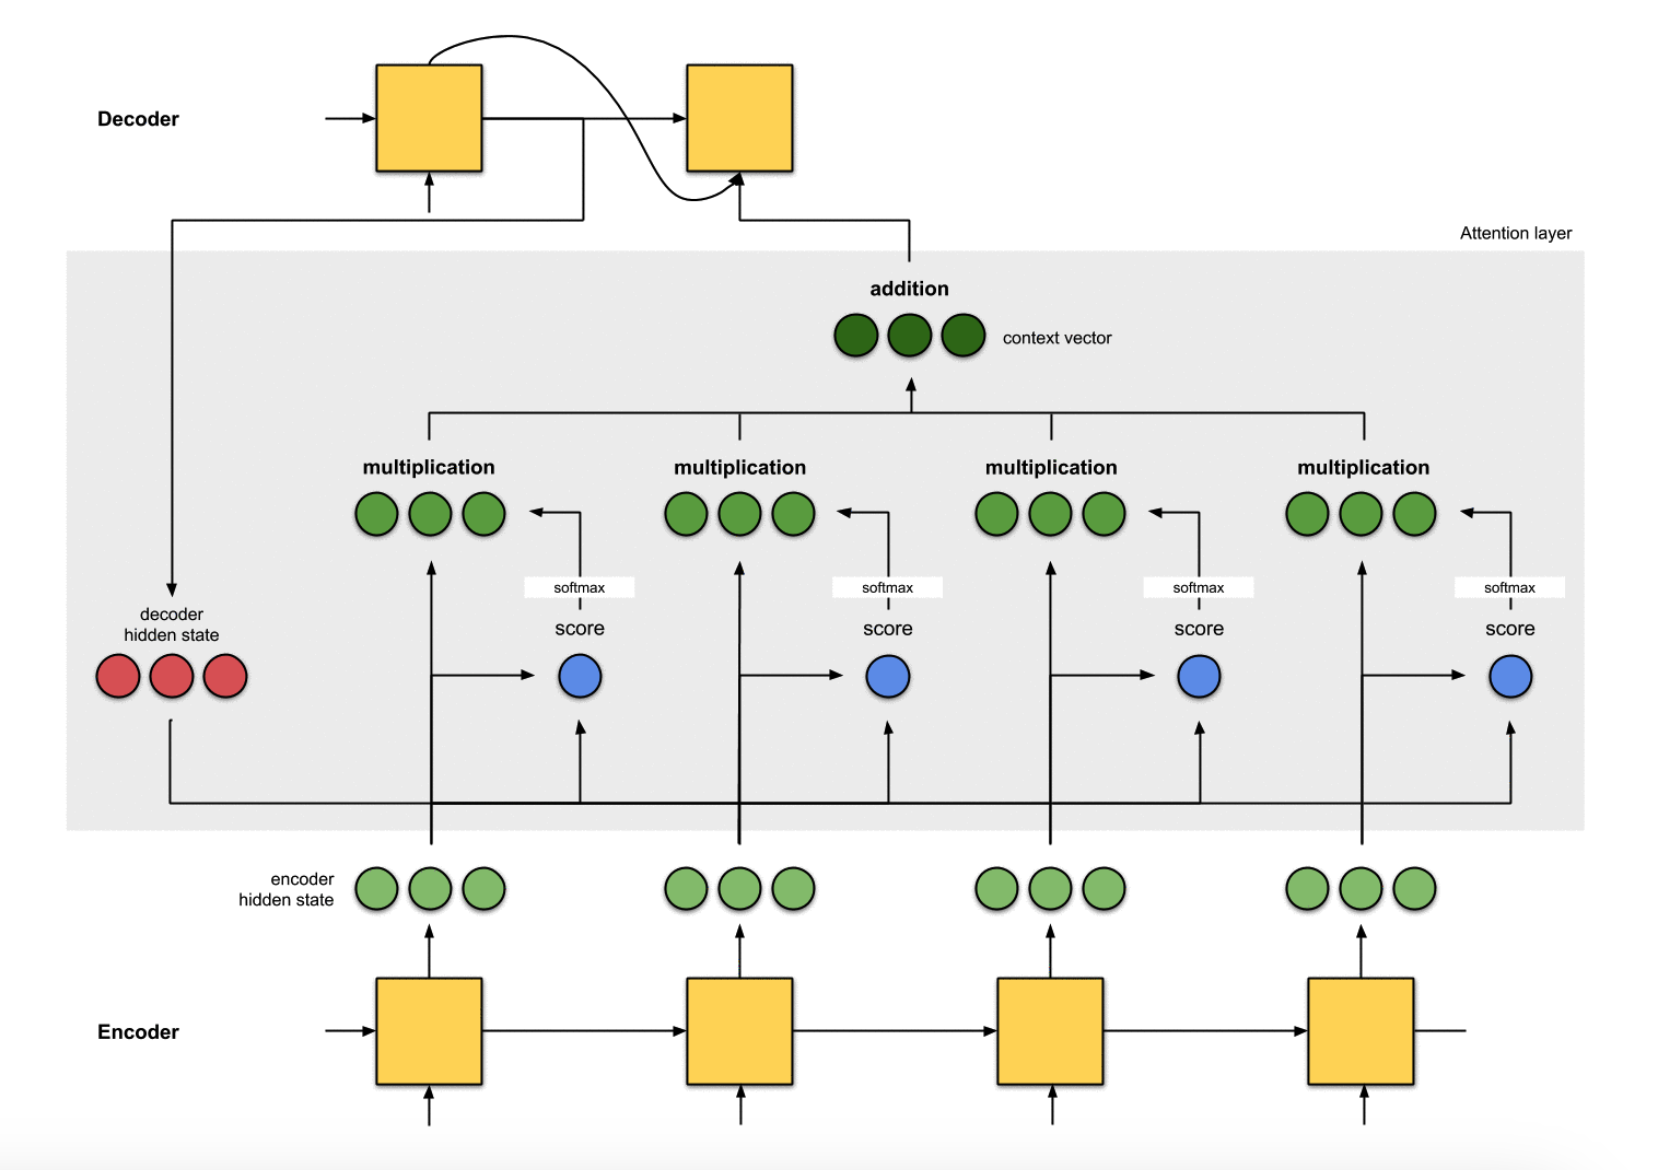


>Q. 블로그 저자의 사견에 따르면 모델의 성능 향상 외에 Attention을 활용할 수 있는 방법이 하나 있습니다. 부산물이라고 표현된 그 방법은 무엇인가요?<br>
A. Attention Map의 **시각화를 통해 모델의 안정성을 점검**할 수 있고, 모델이 의도와 다르게 작동될 경우 그 원인을 찾아내는 데에 이용될 수 있다.


>Q. Sequence Labeling과 Sequence to Sequence의 예시를 하나씩 적고, 두 Task의 차이점에 대해 간단히 설명해봅시다.<br>
A. 
>- Sequence Labeling: 품사 태깅
>- Sequence to Sequence: 번역


### seq2seq과 attn-seq2seq, 뭐가 다른가?
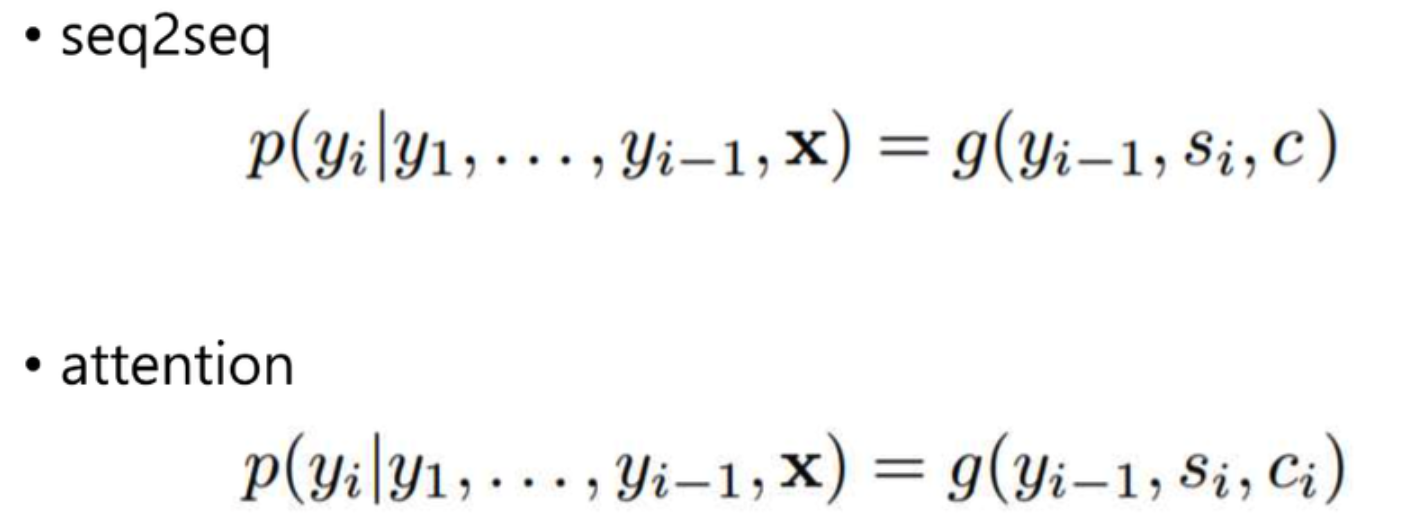

- ci : 인코더가 X를 해석한 context `ci`는 디코더의 포지션 `i`에 따라 다르게 표현(represent)되어야 한다.
- seq2seq에서는 context vector가 고정, attn- 에서는 디코더의 시각에 따라 다르게 표현

### Bahdanau Attention 구현

Bahdanau가 제안한 Attention은 하나의 Baseline이 되어 지금도 여러 기법을 시험하는 데에 멋진 중심점이 되어주고 있습니다. 멋진 기술들의 공통점은 구현한 것을 봤을 때도 이해가 정말 잘 된다는 것이죠! 여기까지의 개념설명이 명확히 와닿지 않았더라도, 구현을 살펴보며 복습을 해봅시다!

- Encoder의 모든 스텝에 대한 Hidden State를 100차원의 벡터 공간으로 매핑 (1, 10, 100) 하고,
- Decoder의 현재 스텝에 대한 Hidden State 역시 100차원의 벡터 공간으로 매핑 (1, 1, 100)해 
- 두 State의 합으로 정의된 Score (1, 10, 1) 를 구하는 모습입니다. 


- Softmax를 거쳐 나온 값은 0-1 사이의 값으로 
    - 각 단어가 차지하는 비중을 의미하겠죠? 
    
    
- 예시에서는 랜덤한 값을 사용했기 때문에 비중이 비슷비슷하지만 
- 실제 단어로 적용시켜보면 유사한 단어에 높은 비중을 할당하게 된답니다!
- 그것을 시각화하면 아래와 같은 그림을 보실 수 있습니다.






In [6]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W_decoder = tf.keras.layers.Dense(units)
    self.W_encoder = tf.keras.layers.Dense(units)
    self.W_combine = tf.keras.layers.Dense(1)

  def call(self, H_encoder, H_decoder):
    print("[ H_encoder ] Shape:", H_encoder.shape)
    
    # 1, 10, 512
    H_encoder = self.W_encoder(H_encoder) 
    print("[ W_encoder X H_encoder ] Shape:", H_encoder.shape)
    print("\n[ H_decoder ] Shape:", H_decoder.shape)
    
    # 
    H_decoder = tf.expand_dims(H_decoder, 1)
    
    H_decoder = self.W_decoder(H_decoder)
    print("[ W_decoder X H_decoder ] Shape:", H_decoder.shape)

    score = self.W_combine(tf.nn.tanh(H_decoder + H_encoder))
    print("[ Score_alignment ] Shape:", score.shape)
    
    attention_weights = tf.nn.softmax(score, axis=1)
    print("\n최종 Weight:\n", attention_weights.numpy())

    context_vector = attention_weights * H_decoder
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

W_size = 100

print("Hidden State를 {0}차원으로 Mapping\n".format(W_size))

attention = BahdanauAttention(W_size)

enc_state = tf.random.uniform((1, 10, 512)) # H_encoder size
dec_state = tf.random.uniform((1, 512)) # H_decoder size

_ = attention(enc_state, dec_state) # init으로 W_size 이미 받았고, W_size를 받은 클래스를 새로 어쩌구 해서 h shape 받음

Hidden State를 100차원으로 Mapping

[ H_encoder ] Shape: (1, 10, 512)
[ W_encoder X H_encoder ] Shape: (1, 10, 100)

[ H_decoder ] Shape: (1, 512)
[ W_decoder X H_decoder ] Shape: (1, 1, 100)
[ Score_alignment ] Shape: (1, 10, 1)

최종 Weight:
 [[[0.09641018]
  [0.07913368]
  [0.09491929]
  [0.09907056]
  [0.06302576]
  [0.11304206]
  [0.09922032]
  [0.10109764]
  [0.12940879]
  [0.12467171]]]


# 10-6. Attention! (2) Luong Attention
---

Bahdanau의 Score 함수와는 다르게 하나의 Weight만을 사용하는 것이 특징입니다. 어떤 벡터 공간에 매핑해주는 과정이 없기 때문에 Weight의 크기는 단어 Embedding 크기와 동일해야 연산이 가능합니다. 이 또한 번역에 적용해보고 성능을 비교해본다면 좋겠죠!

### 2b. Luong et. al (2015) [2]
Effective Approaches to Attention-based Neural Machine Translation의 저자들은 Bahdanau 등에서 아키텍처를 단순화하고 일반화하는 것을 강조했습니다. al. 방법은 다음과 같습니다.

1. 인코더는 2 스택 길이의 LSTM (short-term memory) 네트워크입니다. 디코더 또한 같은 아키텍처를 가지며, 디코더의 초기 hidden state는 마지막 인코더 hidden state입니다.
2. 그들이 실험 한 점수 함수는 (i) additive/concat, (ii) dot product, (iii) location-based, 그리고 (iv) general. 입니다.
3. 현재 디코더 시각 단계로부터의 출력과 현재 시각 단계로부터의 context 벡터 간의 연결은 현재 디코더 시각 단계의 최종 출력(분홍색)을 주기 위해 feed-forward neural network에 공급된다.

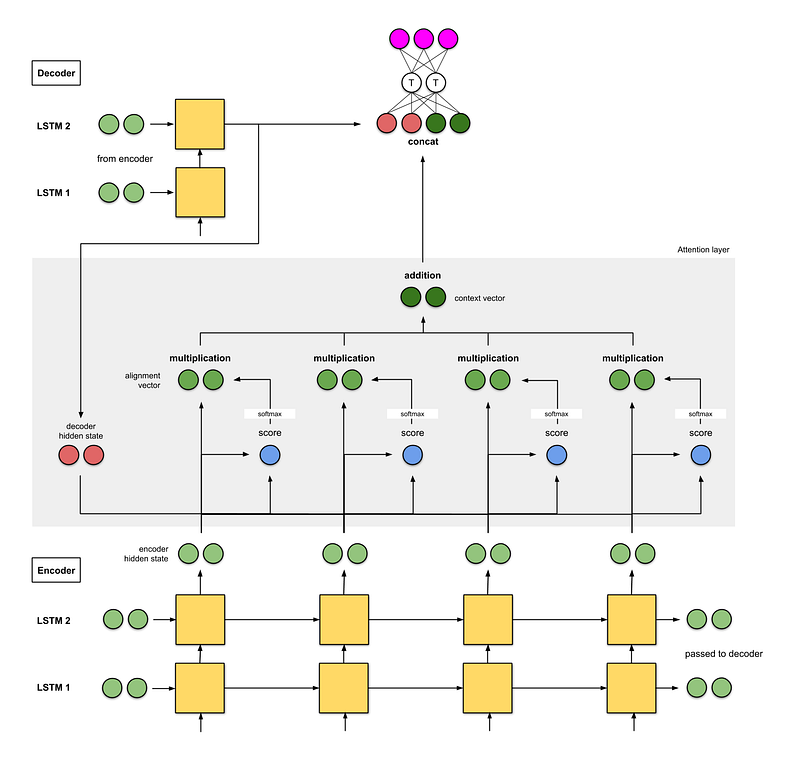

In [9]:
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W_combine = tf.keras.layers.Dense(units)

  def call(self, H_encoder, H_decoder):
    print("[ H_encoder ] Shape:", H_encoder.shape)

    WH = self.W_combine(H_encoder)
    print("[ W_encoder X H_encoder ] Shape:", WH.shape)

    H_decoder = tf.expand_dims(H_decoder, 1)
    alignment = tf.matmul(WH, tf.transpose(H_decoder, [0, 2, 1]))
    print("[ Score_alignment ] Shape:", alignment.shape)

    attention_weights = tf.nn.softmax(alignment, axis=1)
    print("\n최종 Weight:\n", attention_weights.numpy())

    attention_weights = tf.squeeze(attention_weights, axis=-1)
    context_vector = tf.matmul(attention_weights, H_encoder)

    return context_vector, attention_weights

emb_dim = 512

attention = LuongAttention(emb_dim)

enc_state = tf.random.uniform((1, 10, emb_dim))
dec_state = tf.random.uniform((1, emb_dim))

_ = attention(enc_state, dec_state)

[ H_encoder ] Shape: (1, 10, 512)
[ W_encoder X H_encoder ] Shape: (1, 10, 512)
[ Score_alignment ] Shape: (1, 10, 1)

최종 Weight:
 [[[9.8573202e-01]
  [4.5770026e-05]
  [3.0288529e-03]
  [1.3782035e-03]
  [2.6733000e-03]
  [1.7230368e-06]
  [3.4655367e-03]
  [2.3775585e-05]
  [3.6468171e-03]
  [3.9987985e-06]]]


## 10-7. 트랜스포머로 가기 전 징검다리?
---


## 10-8. 마무리하며
---


### Keyword
